# Interpretable Machine Learning
**Aprendizaje Automático Avanzado (AAA)**

_Alan García Justel_

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)

Se van a tratar 5 métricas diferentes para evaluar la interpretabilidad y ganar la confianza de un tercero sobre los resultados de un modelo ya entrenado. Nos vamos a centrar en modelos de clasificación.

## Setup

In [17]:
!pip install scikit-learn pandas alibi

INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 9.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 9.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 11.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 11.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from alibi.explainers import ALE

## Permutation Feature Importance

Nos permite estimar, dado un modelo predictivo ya aprendido, la importancia de
cada variable predictora respecto a las predicciones que realiza el modelo. Resumiendo mucho, ¿cómo se calcula
esta ”importancia”? En el dataFrame que recoge el dataset de entrenamiento, se reordena aleatoriamente la
columna de la variable de interés, se vuelve a aprender un modelo, y la caída en performance de éste se asimila
a la importancia de la variable en dicho modelo: _”permutation feature importance”_. Este proceso se realiza
varias veces y se muestran los resultados agregados.

Para hacer los experimentos se van a generar $1000$ datos sintéticos con $2$ clases y $10$ features de las cuales solo $5$ realmente información.

In [19]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=0,
    shuffle=False,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [14]:

# Entrenar un clasificador RandomForest
feature_names = [f"feature {i}" for i in range(X.shape[1])]
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [15]:

start_time = time.time()
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 0.217 seconds


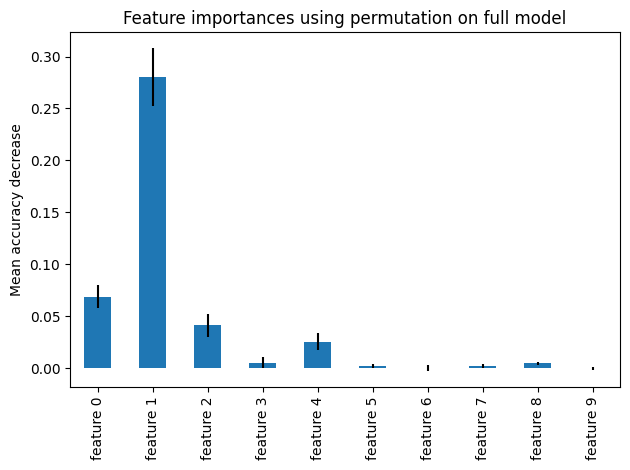

In [16]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Accumulated Local Effects (ALE)

Estimar la _"influencia de cada feature predictora ($X_i$) en la predicción del modelo"_. ALE necesita un output probabilista $p_{NN}(c | \overline{x})$. Para cada feature ($X_i$) de la base de datos se calcula el valor ALE variando tanto hacia arriba como hacia abajo sus valores dejando quietas el resto de variables.

In [38]:
def load_iris_dataset(normalize = True) -> tuple:
    iris = datasets.load_iris(as_frame=True)
    X = iris.data
    y = iris.target

    print(f"[IRIS Dataset]  feature names: {iris.feature_names}, targets: {np.unique(y)}. target names: {iris.target_names}")

    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    return X, y
# Label namemap
classnames = [ "Setosa", "Versicolor", "Virginica" ]
featurenames = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Length"]

# Cargar el Dataset
X, y = load_iris_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


[IRIS Dataset]  feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], targets: [0 1 2]. target names: ['setosa' 'versicolor' 'virginica']


In [32]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

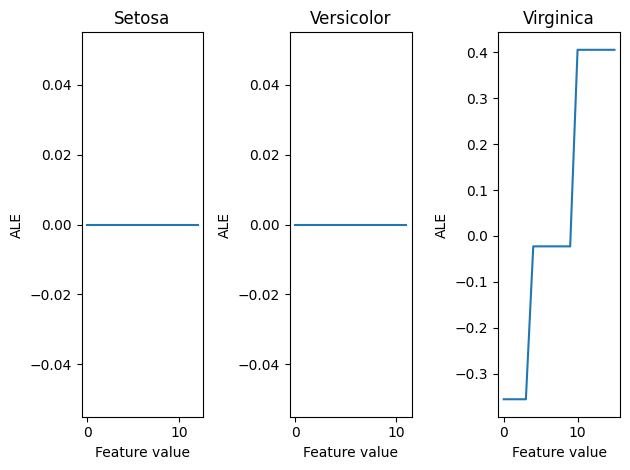

In [40]:
# Initialize ALE explainer
ale = ALE(model.predict, feature_names=featurenames)

# Fit ALE explainer
ale_exp = ale.explain(X_train)

# Plot ALE
fig, ax = plt.subplots(nrows=1, ncols=3)
for i, axi in enumerate(ax.flat):
    if i < len(classnames):
        axi.plot(ale_exp.ale_values[i])
        axi.set_title(classnames[i])
        axi.set_xlabel('Feature value')
        axi.set_ylabel('ALE')
plt.tight_layout()
plt.show()

## Feature 2-Way-Interactions

## Surrogate Trees

Se tiene un modelo ya entrenado. Con este modelo se calcula la columna de predicciones $\hat{C}$ y se genera un dataset con los datos originales $X$ y la columna predecida por el modelo. Con estos datos se entrena un árbol de decisión para intentar explicar o interpretar el output modelo original.

## SHAP values

La medida de oro hoy en día. [Introduction to Shapley values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)